In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'stratiform_rainfall_flux' 
experiment1 = 'control_d0198_RAL3P2_'
experiment2 = 'drysoil_d0198_RAL3P2_'

da1 = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable] #control
da2 = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable] #SM

control = da1.assign_coords(time=da1.time + pd.Timedelta(hours=10))
SM = da2.assign_coords(time=da2.time + pd.Timedelta(hours=10))

variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)

control= control.where(landmask == 1)
SM = SM.where(landmask ==1)

In [3]:
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)
fires = gpd.read_file('/g/data/ng72/as9583/fire/merged_fires.gpkg')

In [4]:
experiments = {
    "control": control,
    "SM" : SM
}

In [5]:
#clip to fires
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da


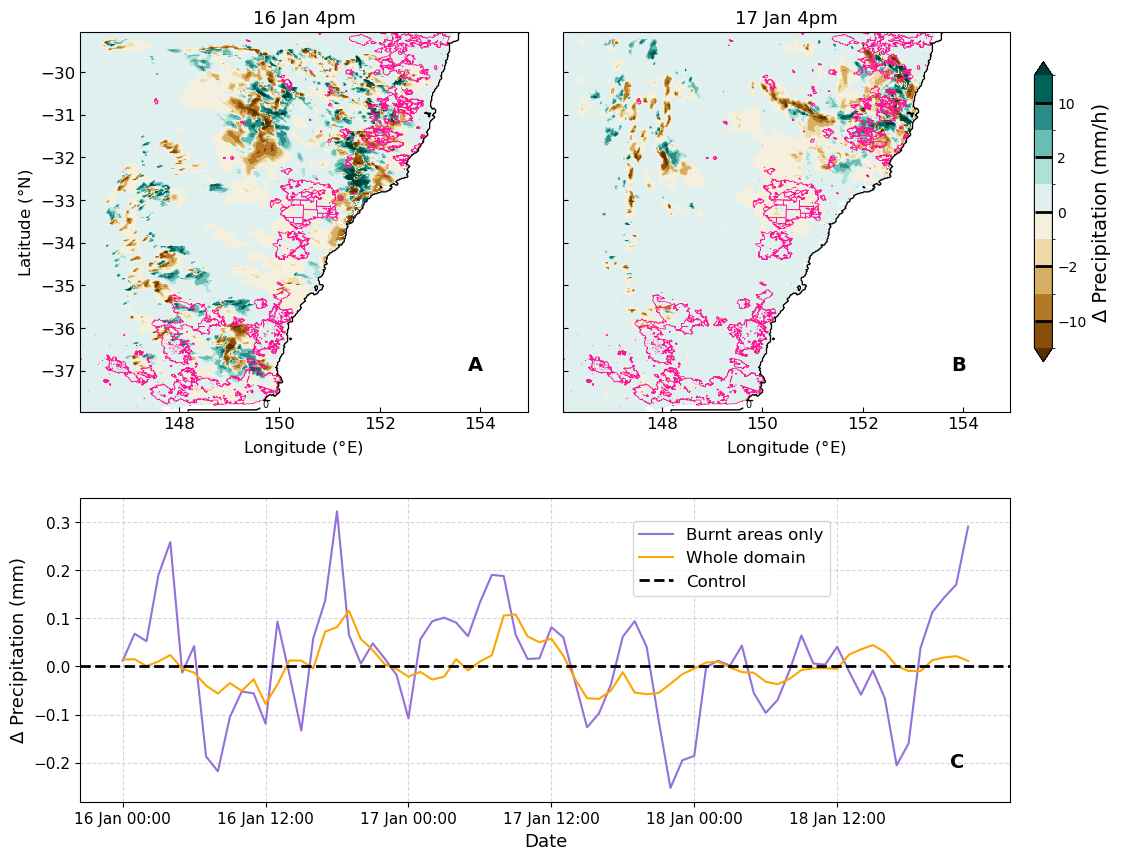

In [9]:
times = ["2020-01-16T16:00", "2020-01-17T16:00"]
titles = ["4pm"]
dates = ["16 Jan", "17 Jan"]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]

selected_key = "SM"  
start_date = "2020-01-16 00:00"
end_date = "2020-01-18 23:59"
color_fire = "mediumpurple"
color_full = "orange"

#-------for timeseries----
diff_hourly_fire = clipped["SM"] - clipped["control"]
da_fire = diff_hourly_fire * 3600  #to mm/h
da_fire_selected = da_fire.sel(time=slice(start_date, end_date))
ts_fire = da_fire_selected.mean(dim=["latitude", "longitude"], skipna=True)
dates_fire = pd.to_datetime(ts_fire.time.values)
diff_hourly_full = SM - control
da_full = diff_hourly_full * 3600  #to mm/h
da_full_selected = da_full.sel(time=slice(start_date, end_date))
ts_full = da_full_selected.mean(dim=["latitude", "longitude"], skipna=True)
dates_full = pd.to_datetime(ts_full.time.values)


#---plotting---

labels = ["A", "B", "C"]

#maps on top, TS below
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.8], width_ratios=[0.45, 0.45], hspace=0.25, wspace=0.08)

#maps
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#time series
ax3 = fig.add_subplot(gs[1, :])

axes = [ax1, ax2]

#---map panels---
for i, t in enumerate(times):
    control_t = control.sel(time=pd.Timestamp(t), method='nearest') * 3600
    SM_t = SM.sel(time=pd.Timestamp(t), method='nearest') * 3600
    diff = (SM_t - control_t).where(landmask == 1)

    im = diff.plot(
        ax=axes[i],
        cmap="BrBG",
        levels=levels,
        add_colorbar=False
    )

    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='deeppink', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title(f'{dates[i]} {titles[0]}', fontsize=13)
    axes[i].text(
        0.9, 0.1, f"{labels[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

ax2.set_ylabel("")  #remove y-axis label
ax2.tick_params(labelleft=False) 

#shared colorbar
cbar_ax = fig.add_axes([0.92, 0.55, 0.015, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Δ Precipitation (mm/h)", fontsize=14)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=12)

#---timeseries panel---
ax3.plot(dates_fire, ts_fire, label="Burnt areas only", color=color_fire)
ax3.grid(True, linestyle = '--', alpha=0.5)
ax3.plot(dates_full, ts_full, label="Whole domain", color=color_full)
ax3.axhline(0, color='k', linestyle='--', label="Control", linewidth = 2)

ax3.set_ylabel("Δ Precipitation (mm)", fontsize=13)
ax3.set_xlabel("Date", fontsize=13)
ax3.legend(loc="center",bbox_to_anchor=(0.7, 0.8),  fontsize=12)

tick_dates = [d for d in dates_fire if d.hour in [0, 12]]
ax3.set_xticks(tick_dates)
ax3.set_xticklabels([d.strftime("%d %b %H:%M") for d in tick_dates], rotation=0, fontsize=11)
ax3.tick_params(axis='both', labelsize=11)
ax3.text(
        0.95, 0.1, labels[2],
        transform=ax3.transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/jan_convective_combined.png', dpi = 300, bbox_inches='tight)
plt.show()
